<a href="https://colab.research.google.com/github/nataliakotsani/ASMA/blob/main/ASMA_Tools_Natalia_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Habitual Frequency

1. Select Button: Upload Files
2. Upload a file with a filename "F0.wav"
3. Choose ok
4. Save the Figure

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving F0.wav to F0 (1).wav
User uploaded file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

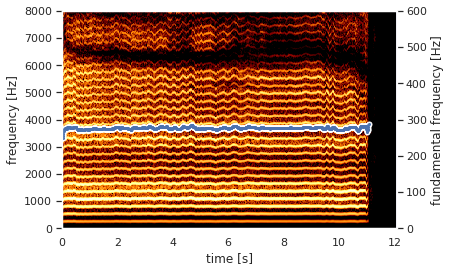

In [ ]:
!pip install praat-parselmouth
import parselmouth
import parselmouth
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import struct
from scipy import signal as sg
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file'.format(
      name=fn, length=len(uploaded[fn])))

sns.set()
snd = parselmouth.Sound('F0.wav')

def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_pitch(pitch):
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

pitch = snd.to_pitch()
pre_emphasized_snd = snd.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch)
plt.xlim([snd.xmin, snd.xmax])
plt.savefig('f0.png')

# Vowel Map

In [ ]:
!pip install praat-parselmouth
import parselmouth
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import struct
from scipy import signal as sg
from parselmouth.praat import call
import statistics
import os
from pathlib import Path
from google.colab import files

def measureFormants(f0min, f0max, p):
    snd = parselmouth.Sound(p)
    pitch = call(snd, "To Pitch (cc)", 0, f0min, 15, 'no', 0.03, 0.45, 0.01, 0.35, 0.14, f0max)
    pointProcess = call(snd, "To PointProcess (periodic, cc)", f0min, f0max)

    formants = call(snd, "To Formant (burg)", 0.1, 5, 5500, 0.025, 30)
    numPoints = call(pointProcess, "Get number of points")

    f1_list = []
    f2_list = []
    f3_list = []
    f4_list = []

    for point in range(0, numPoints):
        point += 1
        t = call(pointProcess, "Get time from index", point)
        f1 = call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
        f2 = call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
        f1_list.append(f1)
        f2_list.append(f2)
    
    f1_list = [f1 for f1 in f1_list if str(f1) != 'nan']
    f2_list = [f2 for f2 in f2_list if str(f2) != 'nan']

    f1_mean = statistics.mean(f1_list)
    f2_mean = statistics.mean(f2_list)

    return (f1_mean, f2_mean)

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file'.format(
      name=fn, length=len(uploaded[fn])))

path='/content/'

files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
x=[]
y=[]
n=[]
l=["A", "E", "I", "O", "U", "Α", "Ε", "Ι", "Ο", "Υ"]

for f in files:
    filename = Path(f).stem
    for i in l:
      if i in filename:
        f1,f2=measureFormants(100, 2000, f)
        x.append(f1)
        y.append(f2)
        n.append('   '+filename)
volume = 20
fig, ax = plt.subplots()
ax.scatter(y, x, s=volume, alpha=0.5, color='purple')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel("F2")
plt.ylabel("F1")
plt.title("VOWELMAP")
for i, txt in enumerate(n):
    ax.annotate(txt, (y[i], x[i]))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.7 MB 2.2 MB/s 


# Phonetogram

# Breathiness

# Nasality